<a href="https://colab.research.google.com/github/ceydab/NLP_Projects/blob/main/NamedEntityRecognition_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Natural Language Processing: Named Entity Recognition using BERT
This notebook shows an example of how to use pretrained models to perform named entity recognition. We will perform the task on Turkish language. We will use two models trained on different sizes of data, and one model with frozen layers.

The notebook follows the structure below:

dataset import,

dataset prepration,

model setup,

finetuning,

evaluation.

In [ ]:
!pip install datasets
!pip install huggingface
!pip install datasets transformers
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none

In [ ]:
from datasets import load_dataset, concatenate_datasets
import sklearn
import huggingface
import transformers
import torch
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
import accelerate
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

After importing the libraries, we import the dataset. We will use polyglot-ner in turkish. The first set will include 1000 rows, second one 3000, and the evaluation set will include 2000 rows.

In [ ]:
train_set1000 = load_dataset('polyglot_ner', 'tr', split='train[:1000]')
train_set3000 = load_dataset('polyglot_ner', 'tr', split='train[:3000]')
eval_set = load_dataset('polyglot_ner', 'tr', split='train[7000:9000]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for polyglot_ner contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/polyglot_ner
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(

Generating train split:   0%|          | 0/607324 [00:00<?, ? examples/s]

Then, we will label the tags, and name the tokenizer for turkish model, both to be used in the encoder.

In [ ]:
# map ner-tags to labels
tags = set()
full_set = concatenate_datasets([train_set1000, train_set3000])
for row in full_set['ner']:
    for tag in row:
        tags.add(tag)
tags_to_labels = {tag: i for i, tag in enumerate(tags)}
labels_to_tags = {v: k for k, v in tags_to_labels.items()}

In [ ]:
model_name = 'dbmdz/bert-base-turkish-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Ner encoding is done in the function below. the function returns the encoded ner rows and lengths for the input.

We will also include a decode_predictions() function in order to map the predicted ner data to labels.

In [ ]:
def encode_dataset(dataset):
    max_len = 512
    enc_set, lengths = [], []

    for words, tags in zip(dataset['words'], dataset['ner']):
      #encode words into tensors, tokenized, padded, and truncated
        enc = tokenizer(words, return_tensors="pt", padding='max_length', max_length=max_len, is_split_into_words=True, truncation=True)
        #assign zeroes to labels for each tensorized token
        enc['labels'] = torch.zeros(1, max_len, dtype=torch.long)
        #assing ner tags to labels, map labels to indices
        for i, tag in enumerate(tags[:max_len]):
            enc['labels'][0][i] = tags_to_labels[tag]

        #simplify tensor's shape
        for key in enc:
            enc[key] = torch.squeeze(enc[key])

        enc_set.append(enc)
        lengths.append(len(tags))
    return enc_set, lengths

In [ ]:
def decode_predictions(predictions,lengths):
    decoded_predictions = []
    logits = predictions.predictions
    for logit, length in zip(logits, lengths):
        # Find the predicted label for each token
        predicted_labels = torch.argmax(torch.tensor(logit), dim=1).tolist()

        # Convert label indices back to tags
        predicted_tags = [labels_to_tags[label] for label in predicted_labels[:length]]

        # Append decoded tags to the decoded predictions
        decoded_predictions.append(predicted_tags)

    return decoded_predictions

In [ ]:
# encode the two training sets and the evaluation set
enc_trainset1, train_lengths1 = encode_dataset(train_set1000)
enc_trainset2, train_lengths2 = encode_dataset(train_set3000)
enc_evalset, eval_lengths = encode_dataset(eval_set)

Once we put all three datasets through encoding, we know move onto training.

As we will use a pretrained BERT classifier, we do not need to implement most of it manually.

We will define the same parameters for the training args for both trainsets. For the third model, we will implement a frozen layer. Then we will test all three models on eval_set.

In [ ]:
def train_predict(dataset, dataset_name):


    model = BertForTokenClassification.from_pretrained(model_name, num_labels=len(tags))
    if dataset_name == "dataset3":
      for param in model.base_model.parameters():
          param.requires_grad = False

    training_args = TrainingArguments(
        output_dir=f'./results_{dataset_name}',
        num_train_epochs=1,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=1,
        weight_decay=0.01,
        logging_dir=f'logs_{dataset_name}',
        no_cuda=False,
    )

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=dataset,
    )

    trainer.train()
    return trainer

trainer1 = train_predict(enc_trainset1, "dataset1")
preds1 = trainer1.predict(enc_evalset)
trainer2 = train_predict(enc_trainset2, "dataset2")
preds2 = trainer2.predict(enc_evalset)
trainer3 = train_predict(enc_trainset2, "dataset3")
preds3 = trainer3.predict(enc_evalset)


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.021300


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.301200


In [ ]:
decode1= decode_predictions(preds1, eval_lengths)
decode2= decode_predictions(preds2, eval_lengths)
decode3= decode_predictions(preds3, eval_lengths)

Now that we have obtained the predictions, we will compare the results using f1 micro and f1 macro. We will also employ confusion matrices

In [ ]:
def compute_metrics(preds, enc_inputs, lengths):

    all_preds = []
    all_labels = []
    count = 0
    o_label = tags_to_labels['O']
    for i, (length, enc_input, labels_wpad, pred_probs_wpad) in enumerate(zip(lengths, enc_inputs, preds.label_ids, preds.predictions)):
        labels = labels_wpad[:length]
        pred_probs = pred_probs_wpad[:length]
        preds = pred_probs.argmax(-1)
        all_preds.extend(preds)
        all_labels.extend(labels)
        for pred in preds:
            if pred != o_label:
                count += 1

    print(f'Count non-O-preds: {count}')
    return {'f1_micro': f1_score(all_labels, all_preds, average='micro'),
            'f1_macro': f1_score(all_labels, all_preds, average='macro')
            }

In [ ]:
print("First model: ", compute_metrics(preds1, enc_evalset, eval_lengths))
print("Second model: ",compute_metrics(preds2, enc_evalset, eval_lengths))
print("Third model: ",compute_metrics(preds3, enc_evalset, eval_lengths))

Count non-O-preds: 1199
First model:  {'f1_micro': 0.9216435293021522, 'f1_macro': 0.24115851358487722}
Count non-O-preds: 1229
Second model:  {'f1_micro': 0.9220162116835927, 'f1_macro': 0.24692034206331936}
Count non-O-preds: 22274
Third model:  {'f1_micro': 0.31103450417714834, 'f1_macro': 0.12749538428154028}


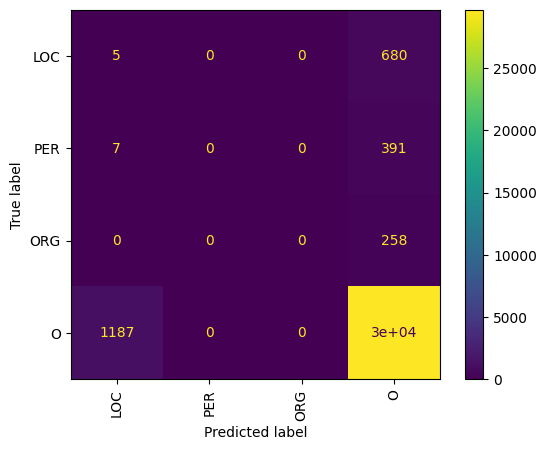

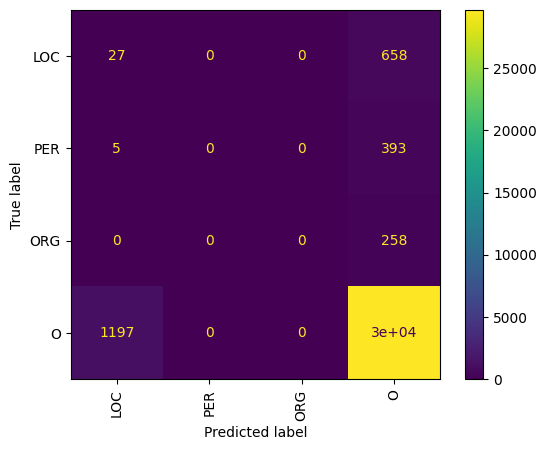

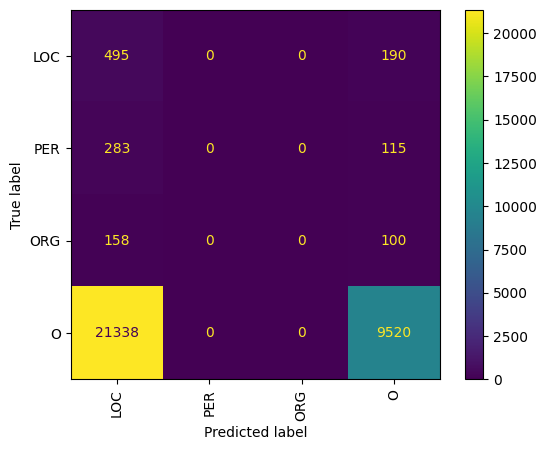

<Figure size 1000x800 with 0 Axes>

In [ ]:
actual_tags = [tag for sublist in eval_set['ner'] for tag in sublist]
predicted_tags1 = [tag for sublist in decode1 for tag in sublist]
predicted_tags2 = [tag for sublist in decode2 for tag in sublist]
predicted_tags3 = [tag for sublist in decode3 for tag in sublist]

assert len(actual_tags) == len(predicted_tags3)
assert len(actual_tags) == len(predicted_tags2)
assert len(actual_tags) == len(predicted_tags1)

actual_labels = [tags_to_labels[tag] for tag in actual_tags]
predicted_labels1 = [tags_to_labels[tag] for tag in predicted_tags1]
predicted_labels2 = [tags_to_labels[tag] for tag in predicted_tags2]
predicted_labels3 = [tags_to_labels[tag] for tag in predicted_tags3]

conf1 = confusion_matrix(actual_labels, predicted_labels1)
conf2 = confusion_matrix(actual_labels, predicted_labels2)
conf3 = confusion_matrix(actual_labels, predicted_labels3)

plot_conf_matrix1 = ConfusionMatrixDisplay(conf1, display_labels=list(tags_to_labels.keys()))
plot_conf_matrix1.plot(include_values=True, xticks_rotation = "vertical")
plot_conf_matrix2 = ConfusionMatrixDisplay(conf2, display_labels=list(tags_to_labels.keys()))
plot_conf_matrix2.plot(include_values=True, xticks_rotation = "vertical")
plot_conf_matrix3 = ConfusionMatrixDisplay(conf3, display_labels=list(tags_to_labels.keys()))
plot_conf_matrix3.plot(include_values=True, xticks_rotation = "vertical")
plt.figure(figsize=(10, 8))
plt.show()

The numbers show a large difference in the metrics for the frozen and non-frozen dataset evaluation, while there is not a distinctive difference for non-frozen dataset evaluation with different sizes.